In [43]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
from numpy.fft import fft, fftfreq
import sklearn 

In [44]:
# Lista de dados lidos do arquivo pkl
data_list = []
pkl_file_path = 'C:\\Users\\pves\\Documents\\Voxar_Contexto\\Workspace\\Deep_Learning\\Projeto\\deep-learn-anomaly-detection\\data\\pickle_files\\'
sampling_freq_audio = 20000
sampling_freq_vibration = 1000

In [45]:
files = os.listdir(pkl_file_path)
pickle_files = []
for file in files:
    if ('.pkl' in file):
        pickle_files.append(file)

print(len(pickle_files))

22


In [46]:
# Funçoes de leitura do arquivo picke
def load_pkl(file_name):
    with open(file_name, 'rb') as pk:
        try:
            lists = pickle.load(pk)

            return lists
        except EOFError:
            pk.close()

            return None
        
def calc_time(sample, freq):
    return np.linspace( 
        0, 
        float(len(sample)) / freq, 
        num = len(sample) 
    )

# Define window size and overlap
def stft(signal, freq):
    # Divide o sinal em janelas
    stft = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal), d=1/freq)
    stft = np.abs(stft.T)[1:int(len(signal)//2)]
    freqs = freqs[1:int(len(signal)//2)]
    return stft, freqs

In [47]:
def plot_graph_keys(amb_noise, color, ax1, ax2, key):
    # Ambient noise
    time = calc_time(amb_noise, sampling_freq_audio)
    amb_fft, amb_freq = stft(amb_noise, sampling_freq_audio)
    ax1.plot(time, amb_noise, color=color)
    ax2.plot(amb_freq, amb_fft, color=color)
    ax1.set_title("Amplitude: " + key)
    ax2.set_title("Magnitude: " + key)


In [48]:
def normalization(array):
    out = []
    min = np.min(array)
    max = np.max(array)

    for i in range(len(array)):
        value = (array[i] - min) / (max - min)
        out.append(value)
    
    return out



In [49]:
# Process each file and stores in the datalist
# datalist - > lista com os 22 arquivos de motor 
for i in range(len(pickle_files)):
    file_pkl = '{}'.format(pickle_files[i])
    pkl = load_pkl(pkl_file_path + file_pkl)
    if (pkl != None):
        data_list.insert(i, pkl)

In [50]:
print(len(data_list))
print(data_list[0][0].keys())

22
dict_keys(['date_time', 'temperature', 'noise_amb', 'noise_eng', 'gyr_x', 'gyr_y', 'gyr_z', 'acc_x', 'acc_y', 'acc_z'])


In [51]:
columns = ['noise_amb', 'noise_eng', 'gyr_x', 'gyr_y', 'gyr_z', 'acc_x', 'acc_y', 'acc_z', 'class']
dict_list = data_list[0]
print(len(dict_list))
sample = dict_list[0]
print(len(sample['noise_amb']))


250
500


In [52]:
m1_dataframe = pd.DataFrame(columns=columns)
m2_dataframe = pd.DataFrame(columns=columns)
m3_dataframe = pd.DataFrame(columns=columns)

Descrição do dicionário
* Temperatura - > escalar (float)
* Data_time: String com a data e a hora de aquisição
* noise_amb -> leitura do sensor de audio ambiente (500 amostras - serie temporal)
* noise_eng - > leitura do sensor de audio motor (500 amostras - serie temporal)
* gyr_x, y, z - > leitura do eixo-x do giroscópio (1000 amostras - série temporal)
* acc_x, y, z -> leitura do eixo-x do acelerômetro (1000 amostras - série temporal)


C:\Users\pves\AppData\Local\Temp\ipykernel_22208\1575543244.py:93: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))


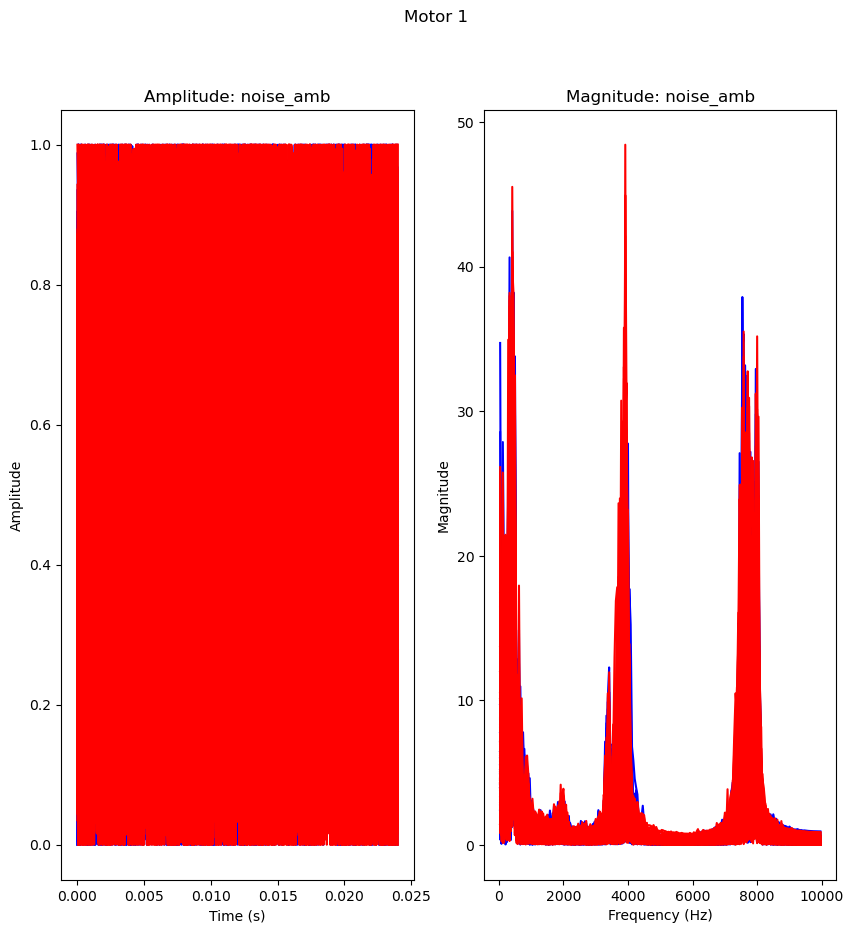

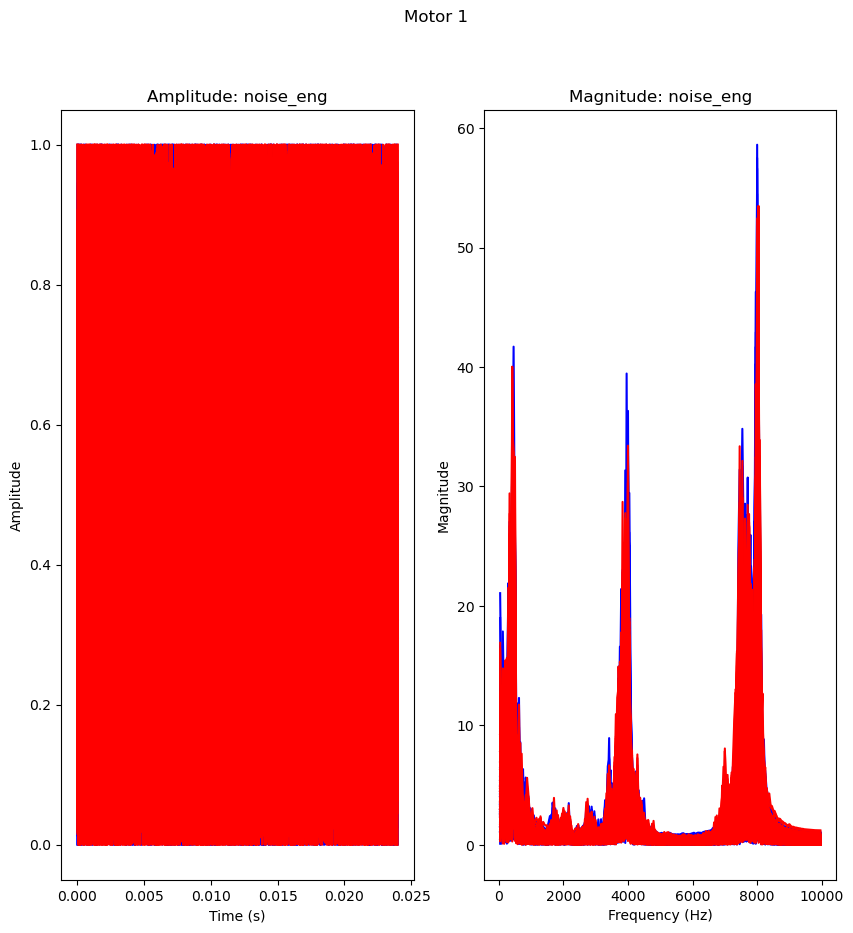

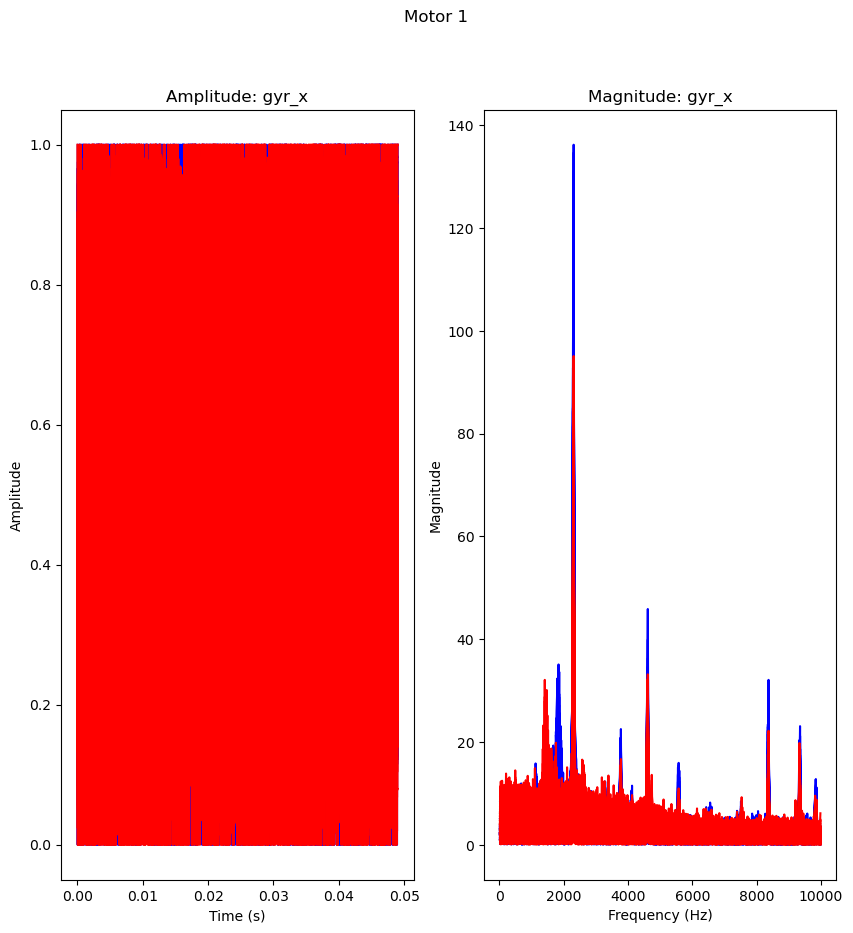

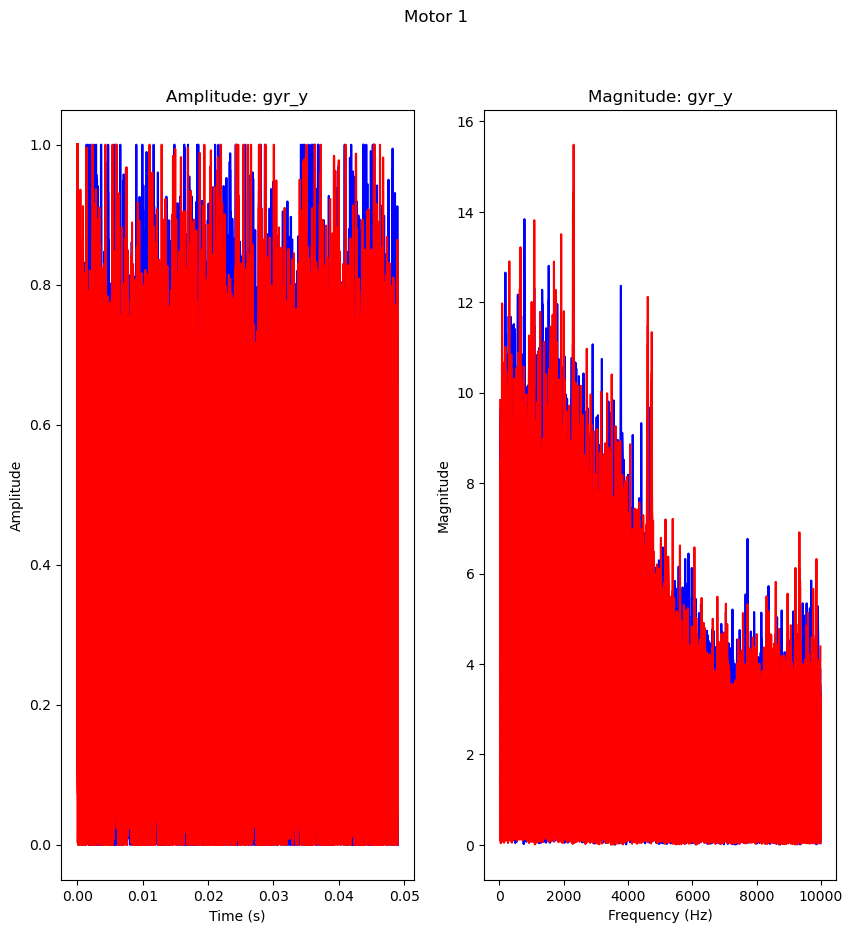

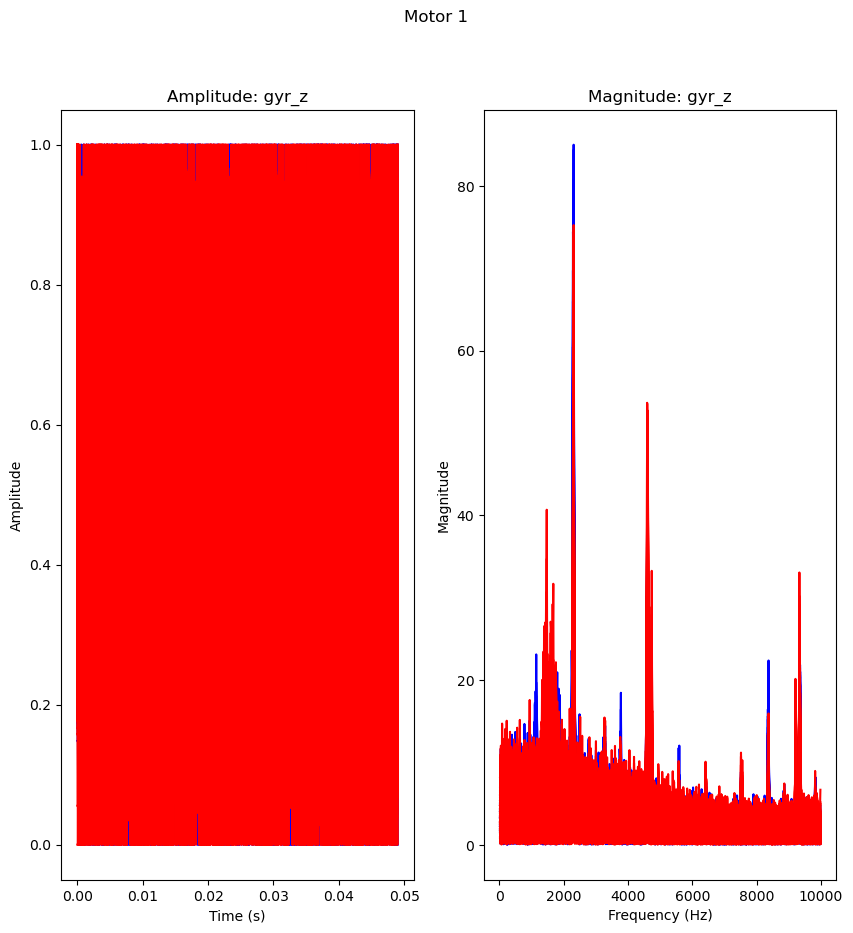

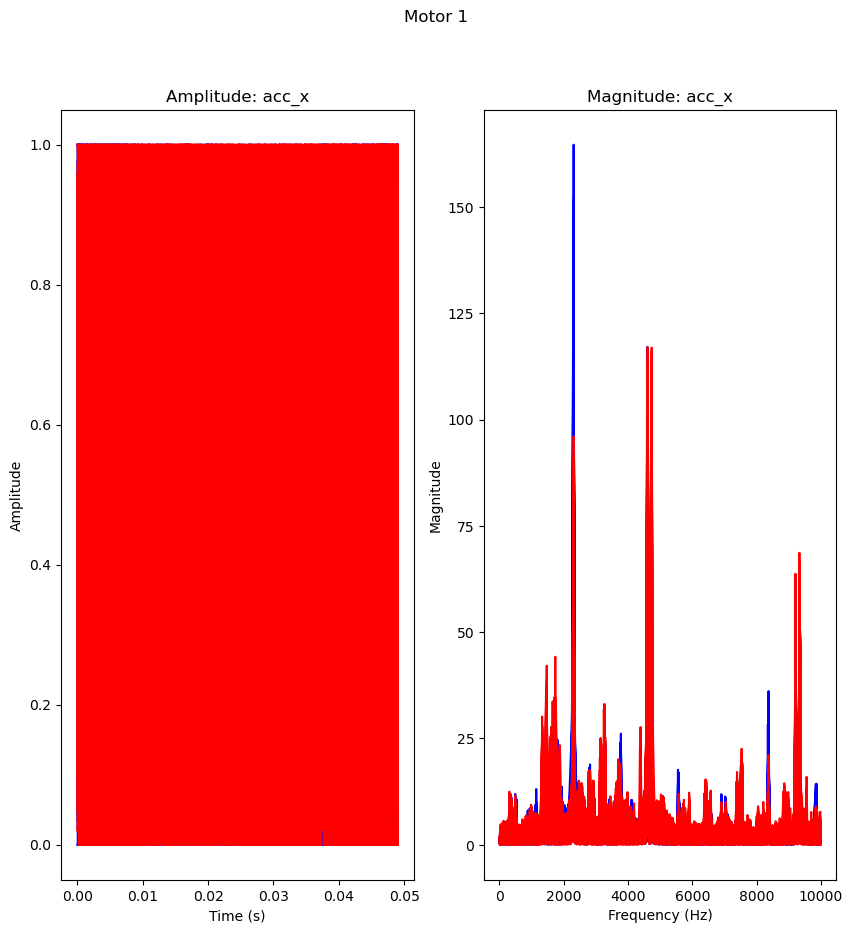

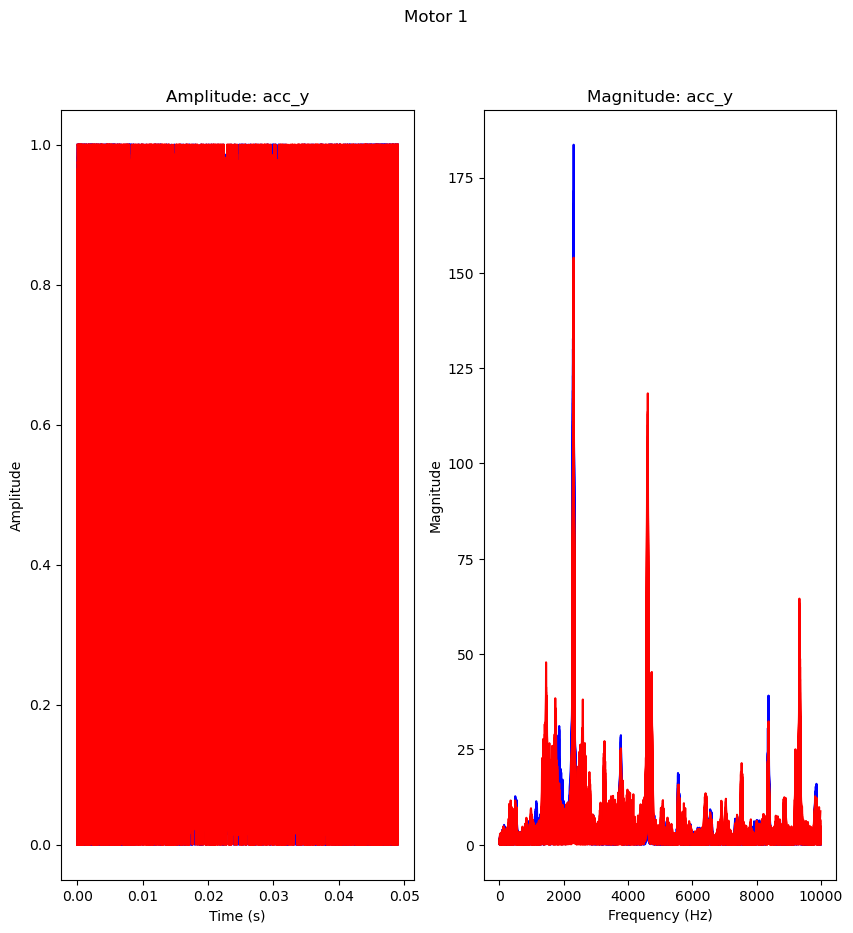

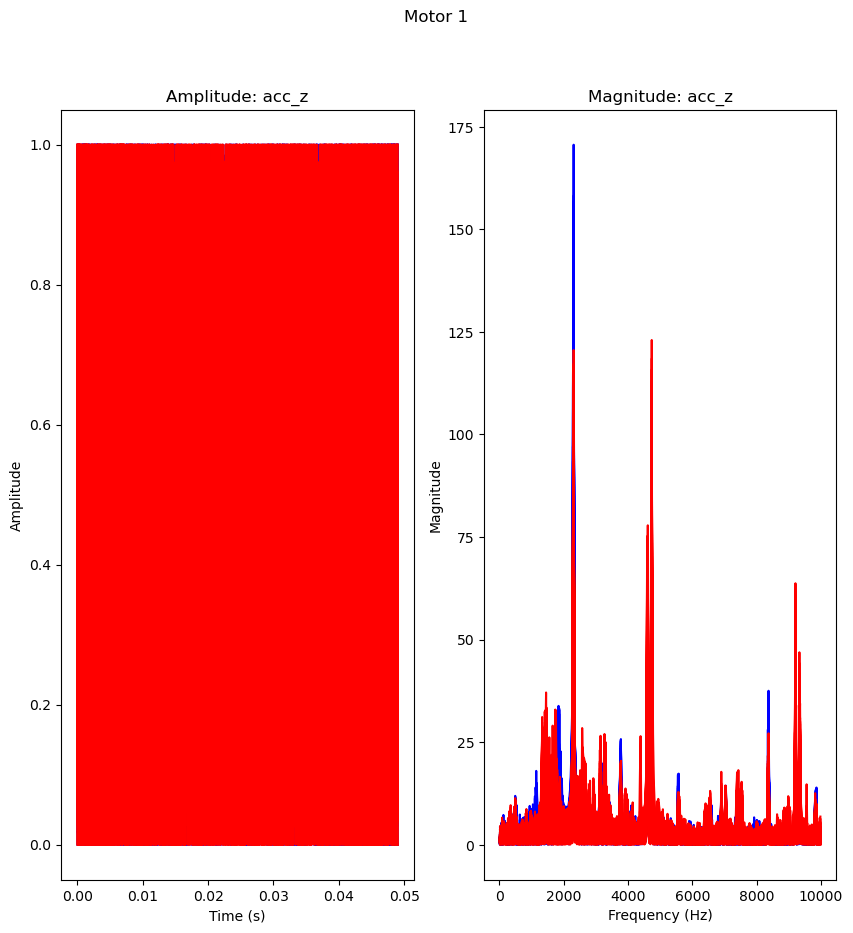

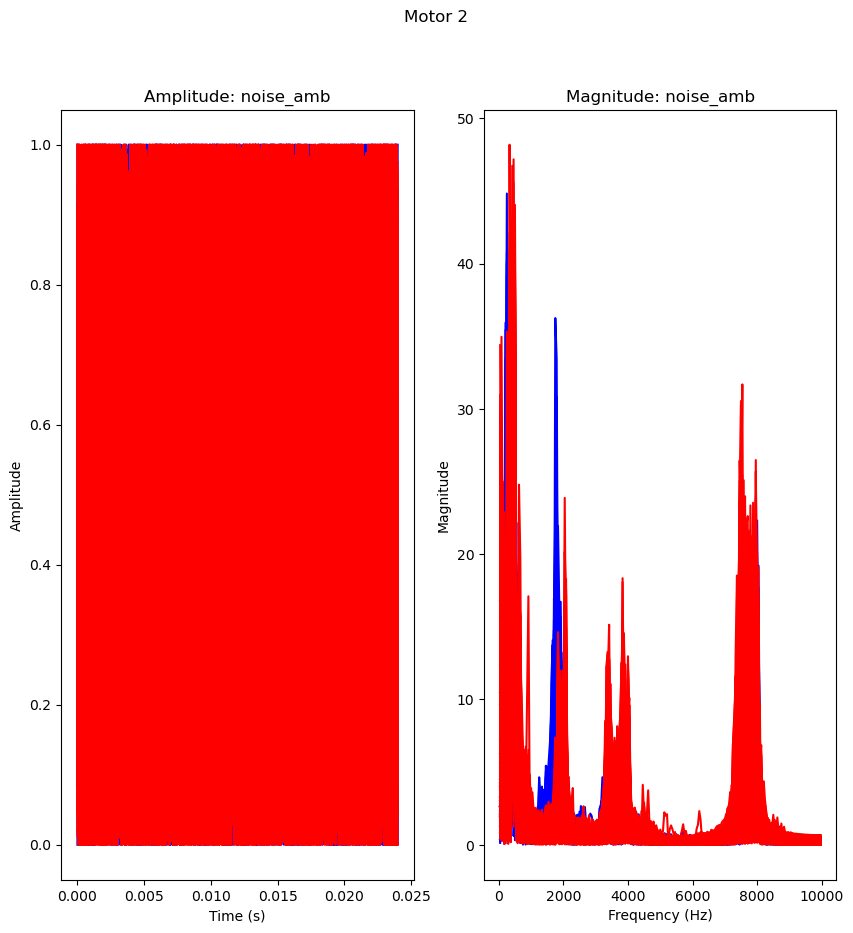

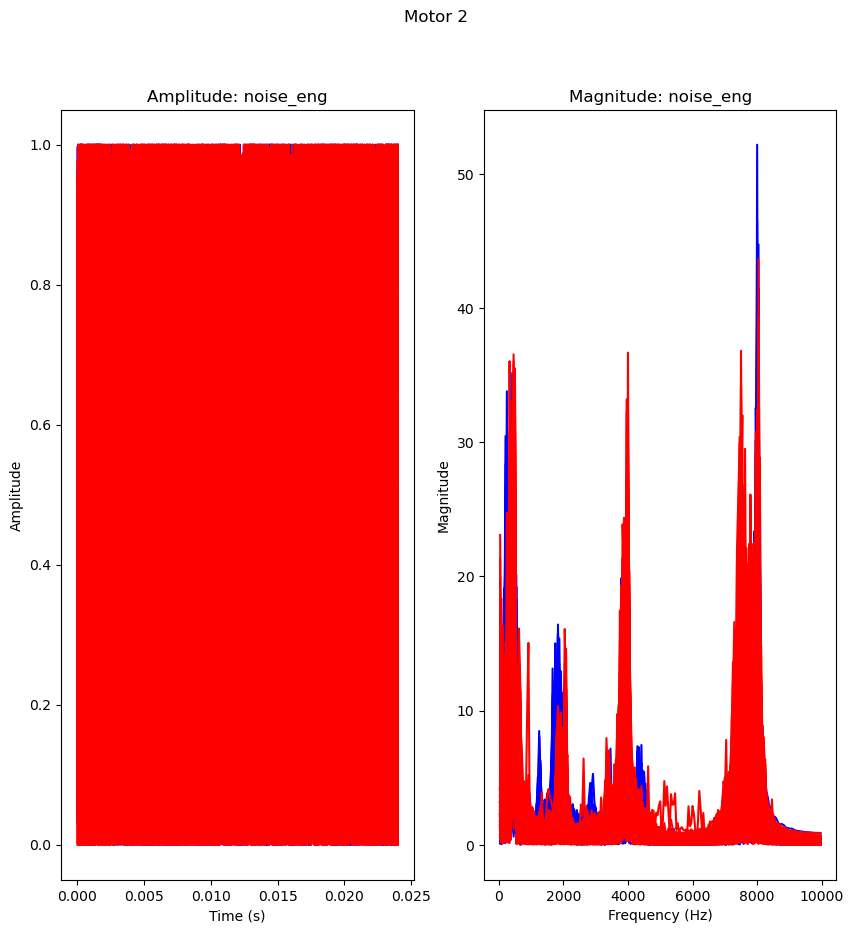

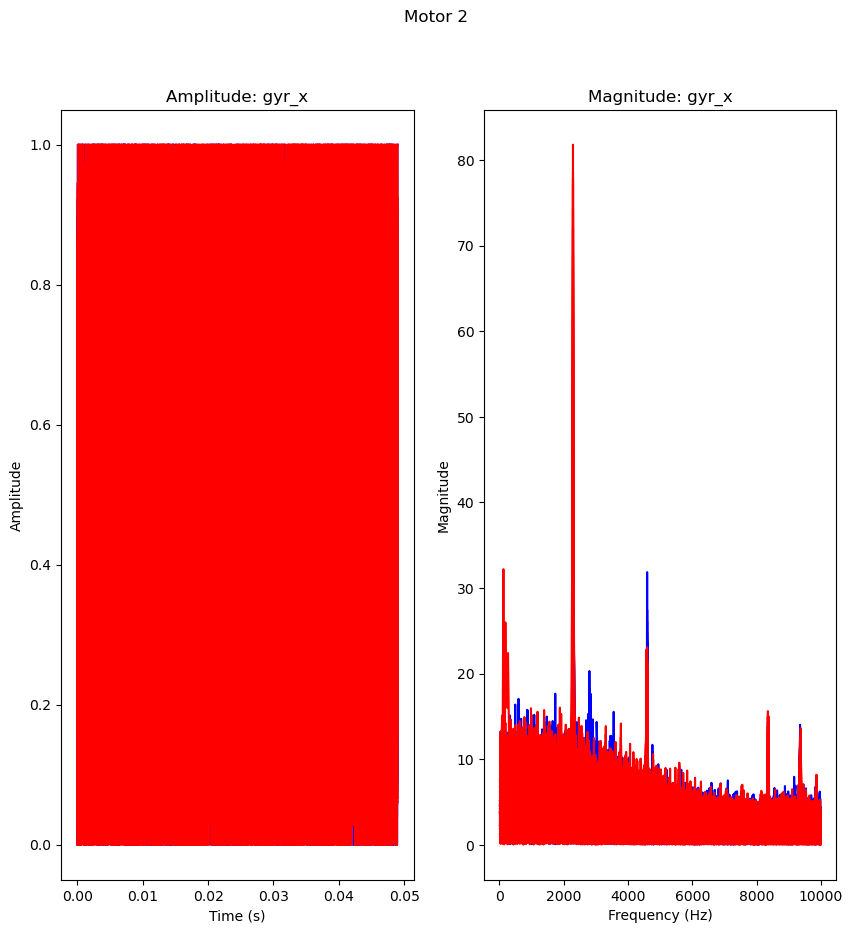

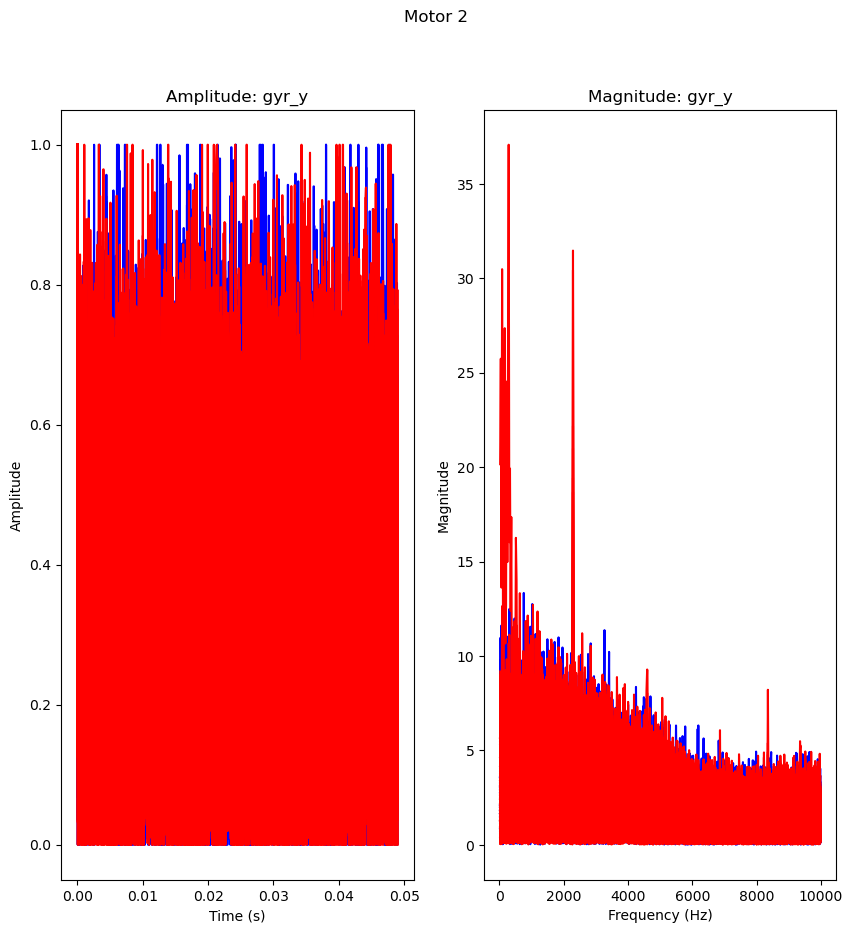

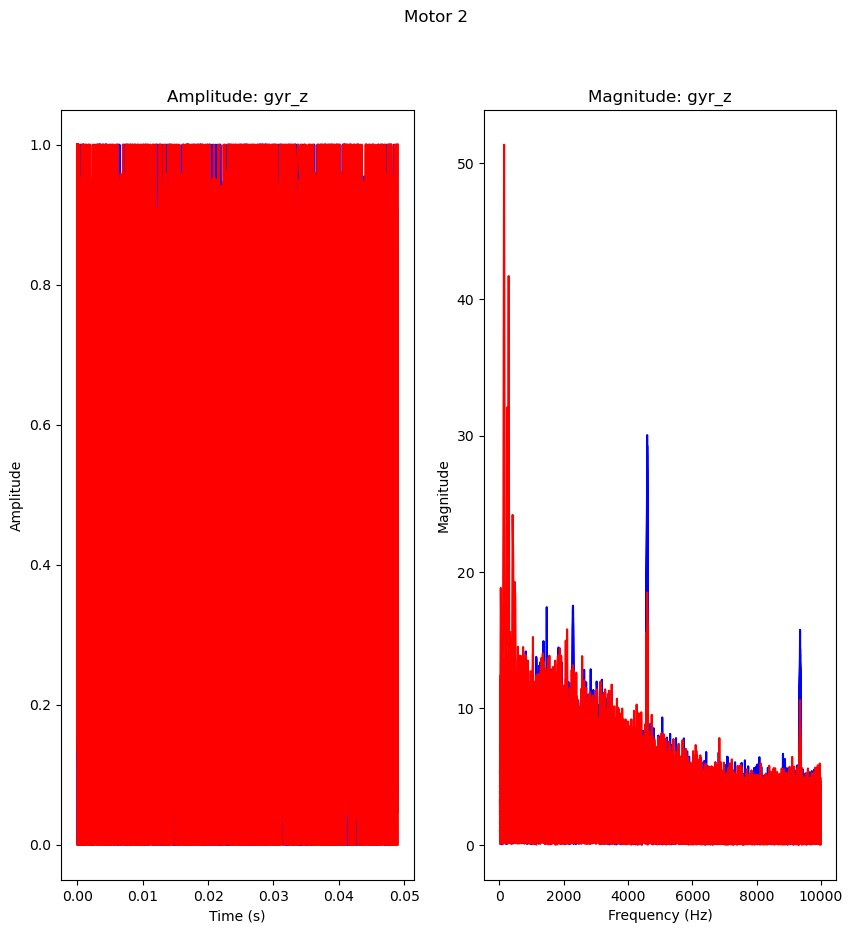

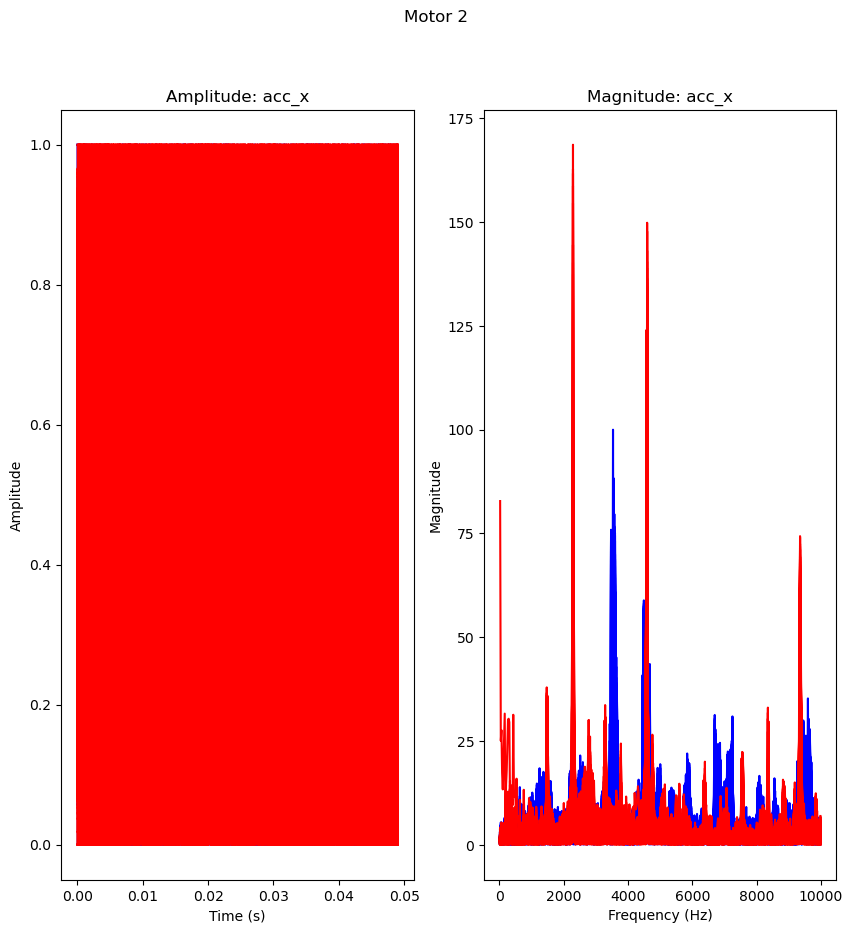

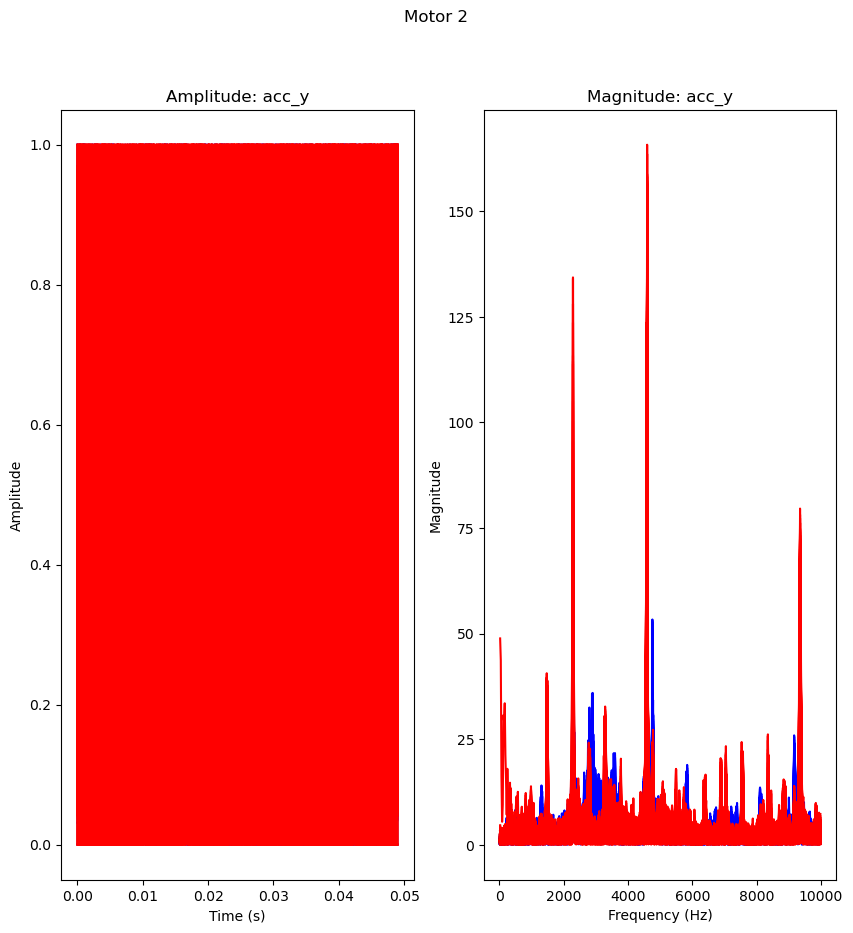

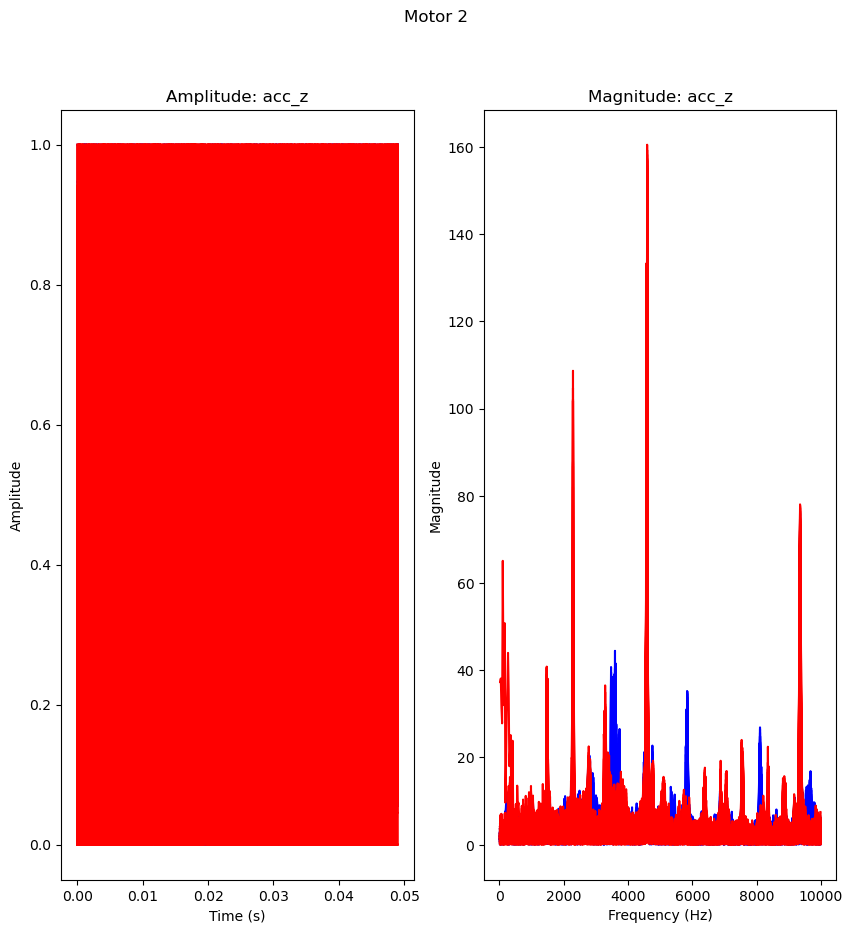

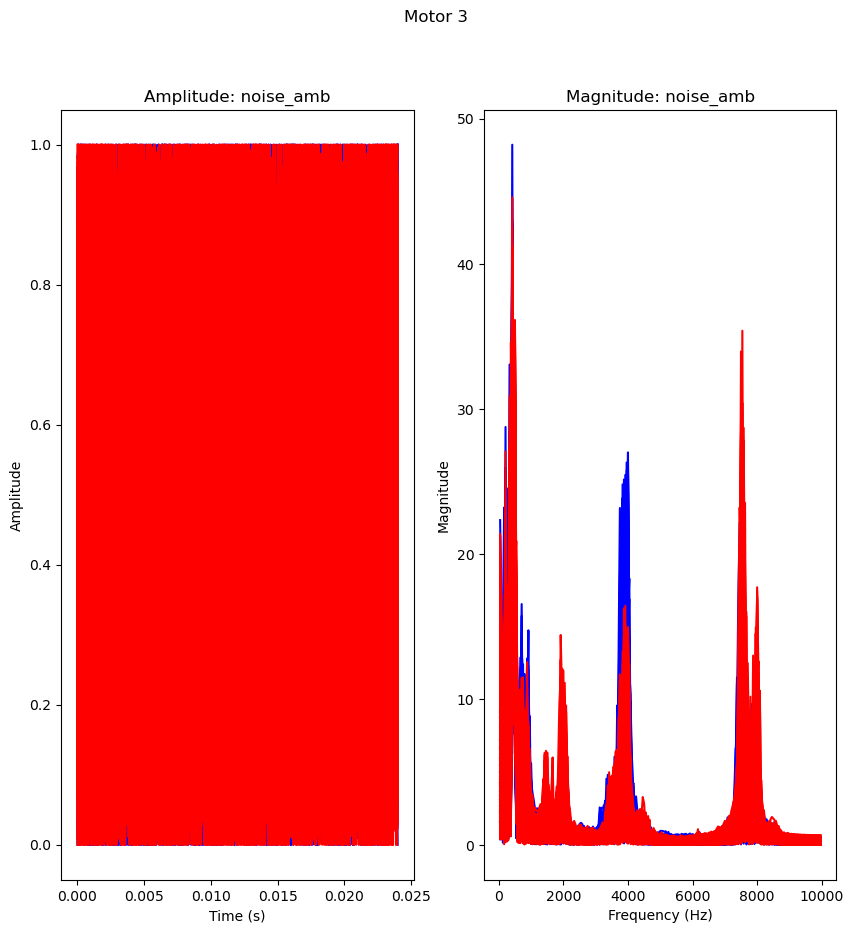

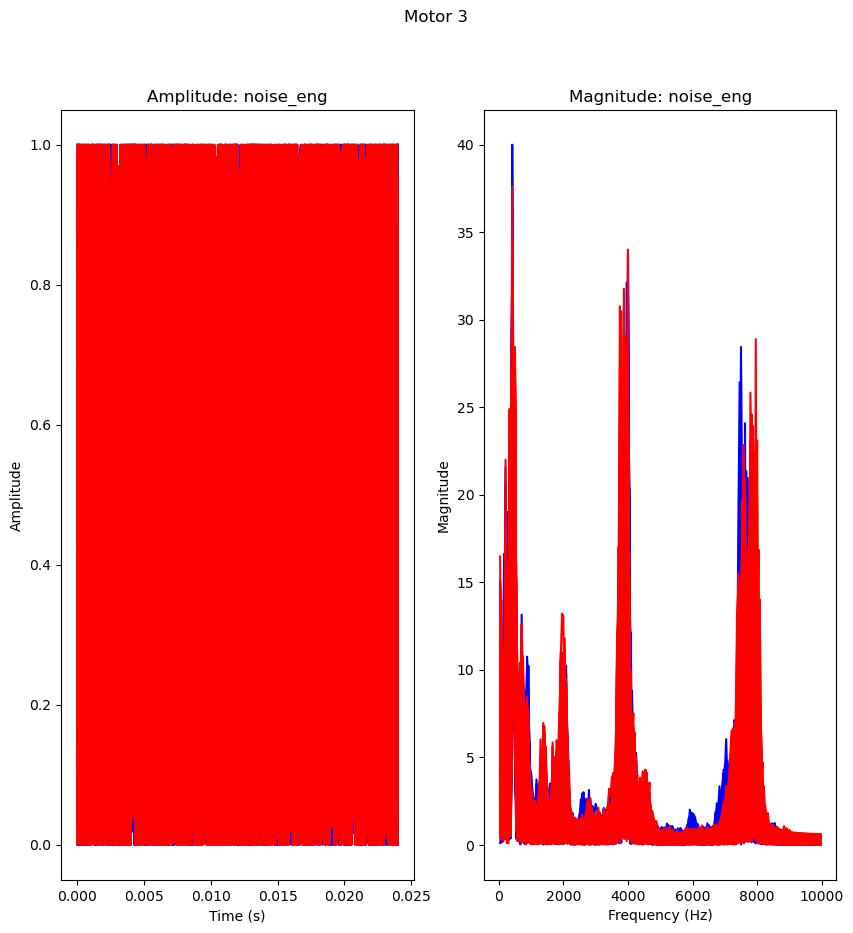

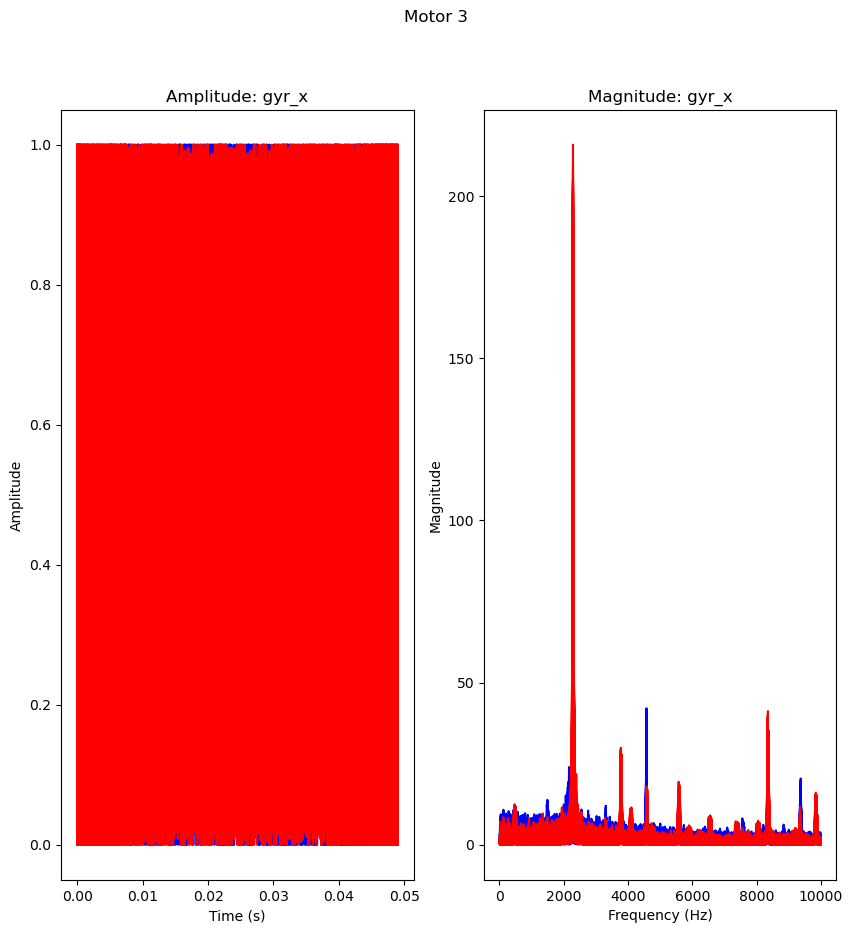

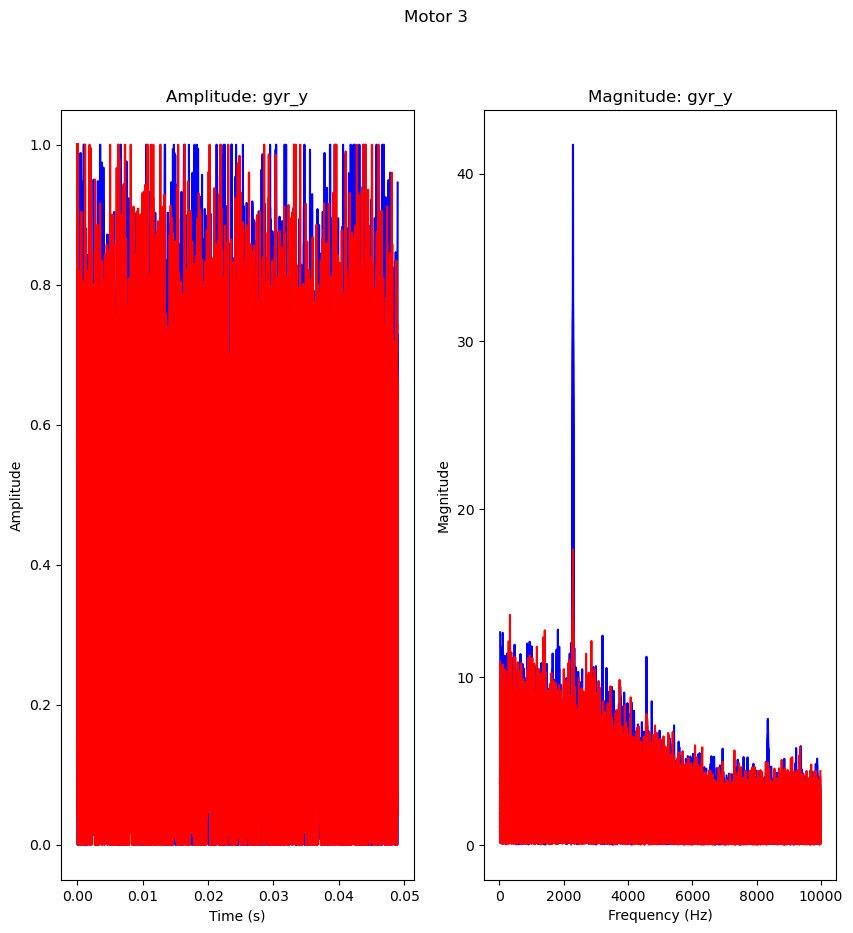

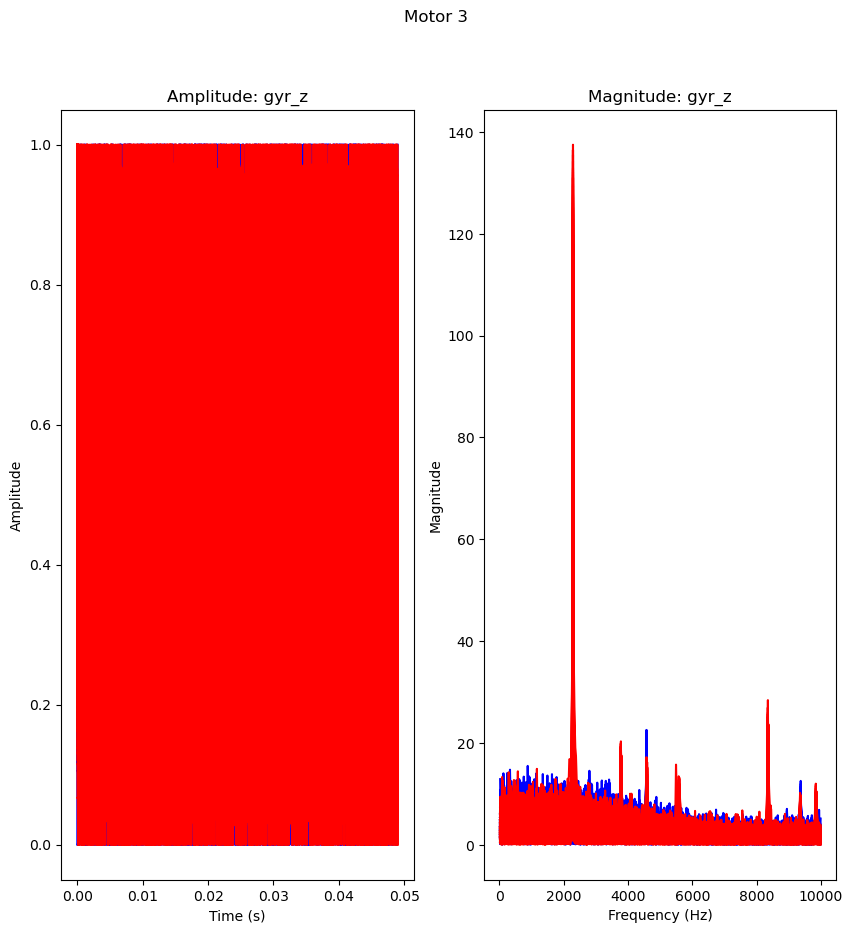

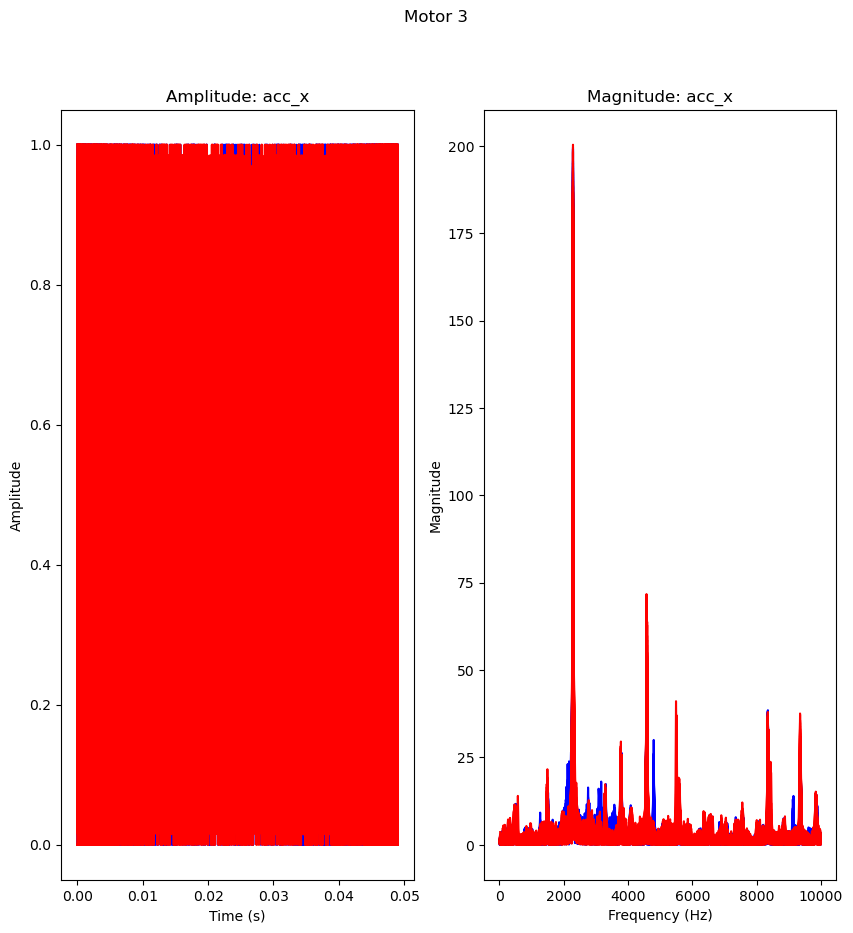

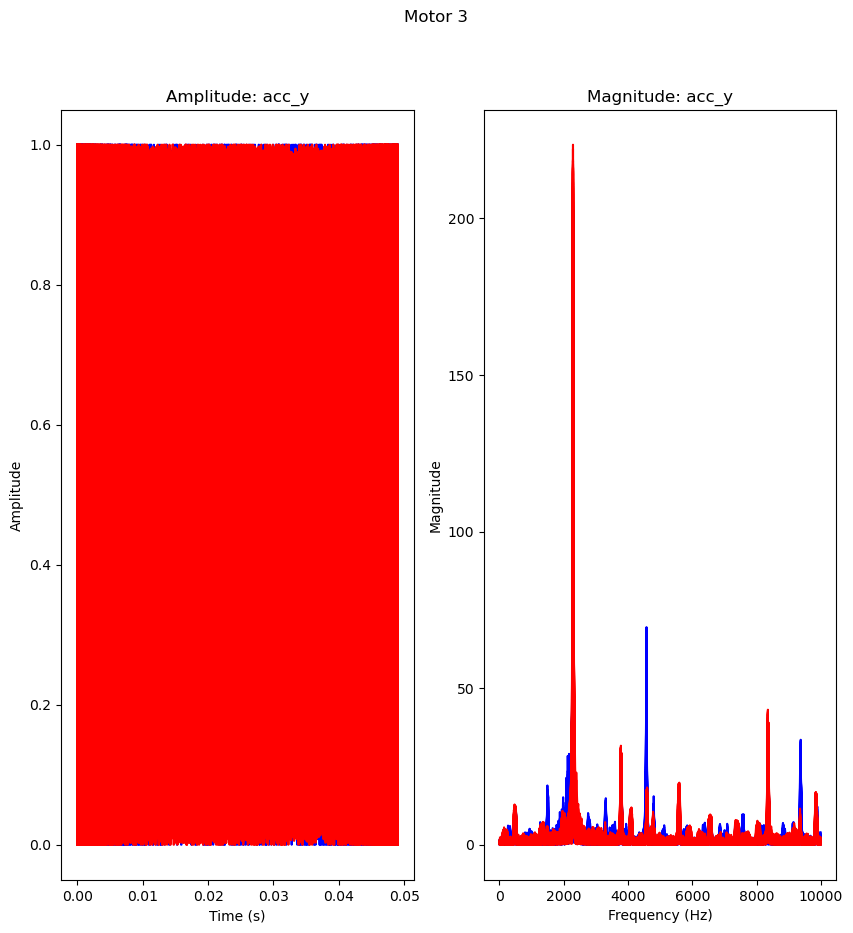

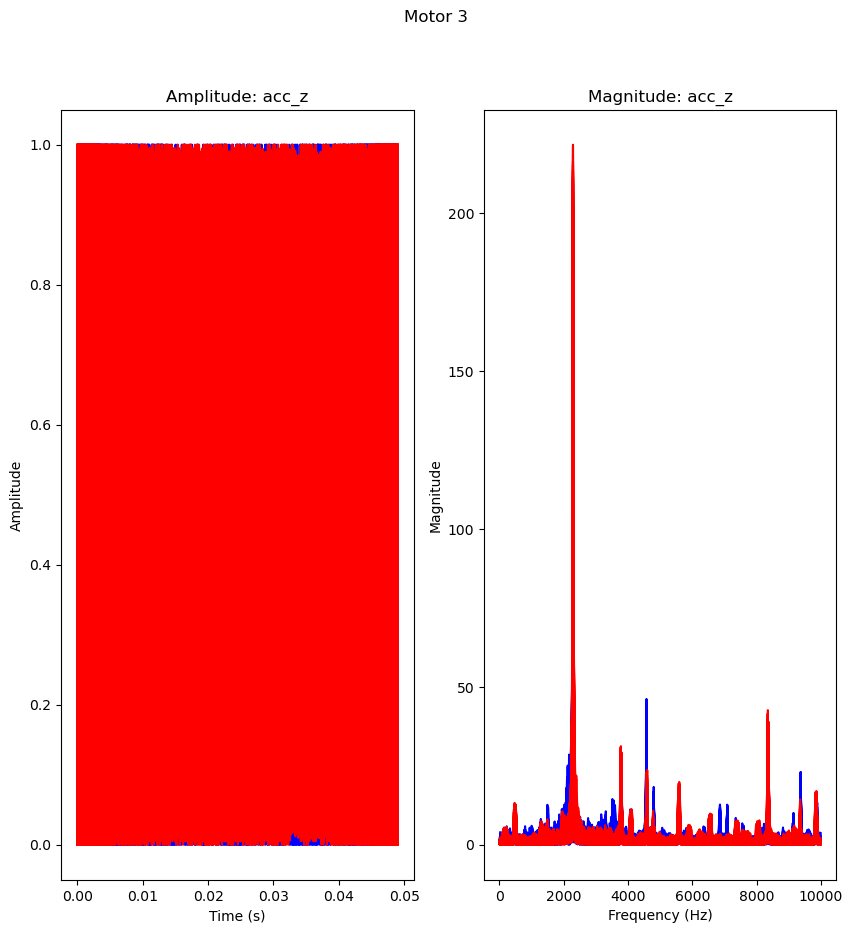

In [53]:
# O Motor 1 compreende o intervalo de 0 ao 6
# Anomalia: 0-2 - Azul
# Normal: 3 - 6 - Vermelho

# O Motor 2 - compreende o intervalo de 7 - 14
# Anomalia: 7-9
# Normal: 10-14

# O Motor 3 - compreende o intervalo de 15 - 21
# Anomalia: 15-17
# Normal: 18-22

tuple_figs = []
keys_list = sample.keys()
color = 'b'
label_ = "Anomaly"
eng_name = "Motor 1"
target = 0

for i in range(2,len(keys_list)):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Amplitude")
    ax2.set_xlabel("Frequency (Hz)")
    ax2.set_ylabel("Magnitude")
    fig.suptitle(eng_name)
    tuple_figs.append((fig, ax1, ax2))

#print(f"Number of Figures {len(tuple_figs)}")

for i in range(len(data_list)):

    aux_dataframe = pd.DataFrame(columns=columns)
    if (i <= 2 or (i >= 7 and i <= 9) or (i >= 15 and i <= 17)):
        color = 'b'
        label_ = "Anomaly"
        target = 1
    else:
        color = 'r'
        label_ = "Normal"
        target = 0

    for idx, sample_dict in enumerate(data_list[i]):
        
        for k, key in enumerate(keys_list):
            if ('temp' in key or 'date' in key):
                 pass
            else:
                (fig, ax1, ax2) = tuple_figs[k - 2]
                data = sample_dict[key]
                data = data[10:-10]
                data = normalization(data)
                plot_graph_keys(data, color, ax1, ax2, key)

                x = np.array(data).T
                # Keeping the window lenght fix in 500 points
                if (x.shape[0] > 480):
                    x = x[0:480]

                #sprint(len(x))
                aux_dataframe[key] = x                              # Saves every columns of the dataframe    

        # Adding labels of the columns
        if (target == 1):
            y = np.ones(shape=(aux_dataframe.shape[0],), dtype=int)
        else:
            y = np.zeros(shape=(aux_dataframe.shape[0],), dtype=int)

        aux_dataframe['class'] = y
        # Save data on Motor 1, 2 or 3
        if (i <= 6):
            m1_dataframe = pd.concat([m1_dataframe, aux_dataframe], axis=0, ignore_index=True)
        elif (i <= 14):
            m2_dataframe = pd.concat([m2_dataframe, aux_dataframe], axis=0, ignore_index=True)
        else:
            m3_dataframe = pd.concat([m3_dataframe, aux_dataframe], axis=0, ignore_index=True)
        
        # Clear all aux_dataset
        aux_dataframe.drop(aux_dataframe.index[0:aux_dataframe.shape[0]], inplace=True)

        if (idx == 99):
            break
        
    if (i == 6 or i == 14):
        tuple_figs.clear()
        if (i == 6):
            eng_name = "Motor 2"
        
        if (i == 14):
            eng_name = "Motor 3"
        
        for i in range(2,len(keys_list)):
            fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
            ax1.set_xlabel("Time (s)")
            ax1.set_ylabel("Amplitude")
            ax2.set_xlabel("Frequency (Hz)")
            ax2.set_ylabel("Magnitude")
            fig.suptitle(eng_name)
            tuple_figs.append((fig, ax1, ax2))
plt.show()

In [54]:
print(m1_dataframe.shape)
print(m2_dataframe.shape)
print(m3_dataframe.shape)

(336000, 9)
(384000, 9)
(336000, 9)


In [55]:
# Saving all dataframes
m1_dataframe.to_csv('C:\\Users\\pves\\Documents\\Voxar_Contexto\\Workspace\\Deep_Learning\\Projeto\\deep-learn-anomaly-detection\\data\\m1.csv')
m2_dataframe.to_csv('C:\\Users\\pves\\Documents\\Voxar_Contexto\\Workspace\\Deep_Learning\\Projeto\\deep-learn-anomaly-detection\\data\\m2.csv')
m3_dataframe.to_csv('C:\\Users\\pves\\Documents\\Voxar_Contexto\\Workspace\\Deep_Learning\\Projeto\\deep-learn-anomaly-detection\\data\\m3.csv')

In [62]:
m1_dataframe.shape

(336000, 9)

In [57]:
m1_dataframe.tail()

,noise_amb,noise_eng,gyr_x,gyr_y,gyr_z,acc_x,acc_y,acc_z,class
335995,0.203956,0.310433,0.609756,0.444444,0.666667,0.105263,0.310345,0.488372,0
335996,0.218622,0.157662,0.634146,0.511696,0.666667,0.105263,0.574713,0.511628,0
335997,0.179059,0.091057,0.634146,0.336257,0.444444,0.789474,0.574713,0.511628,0
335998,0.306617,0.293200,0.597561,0.473684,0.555556,0.631579,0.850575,0.348837,0
335999,0.123806,0.455752,0.439024,0.473684,0.555556,0.578947,0.735632,0.279070,0


In [64]:
anomaly = m1_dataframe[m1_dataframe['class'] == 1]
normal = m1_dataframe[m1_dataframe['class'] == 0]
print(anomaly.shape)
print(normal.shape)

(144000, 9)
(192000, 9)


In [65]:
def generate_data(X, y, sequence_length = 10, step = 1):
    X_local = []
    y_local = []
    for start in range(0, len(X) - sequence_length, step):
        end = start + sequence_length
        X_local.append(X[start:end])
        y_local.append(y[end-1])
    return np.array(X_local), np.array(y_local)

In [68]:
(x_anomally, y_anomally) = generate_data(anomaly.iloc[:,:-1].values, anomaly['class'].values, sequence_length = 480, step=480)
(x_normal, y_normal) = generate_data(normal.iloc[:,:-1].values, normal['class'].values, sequence_length=480, step=480)
print("X_anomally shape and y anomally shape = {a}, {b}".format(a = x_anomally.shape, b = y_anomally.shape))
print("X_normal shape and y normal shape = {a}, {b}".format(a = x_normal.shape, b = y_normal.shape))

X_anomally shape and y anomally shape = (299, 480, 8), (299,)
X_normal shape and y normal shape = (399, 480, 8), (399,)


In [69]:
# Separating the test and training sets
training = 0.7
validation = 0.1
test = 0.2

############# - X Partitioning- ######################################################################################
end_a = int(len(x_anomally) * training)
end_n = int(len(x_normal) * training)

x_train_anomally = x_anomally[: end_a]
x_train_normal = x_normal[: end_n]

x_validation_anomally = x_anomally[end_a : end_a + int(len(x_anomally) * validation)]
x_validation_normal = x_normal[end_n : end_n + int(len(x_normal) * validation)]
end_n = end_n + int(len(x_normal) * validation)
end_a = end_a + int(len(x_anomally) * validation)

x_test_anomally = x_anomally[end_a :]
x_test_normal = x_normal[end_n  : ]


############# - Y Partitioning- ######################################################################################

end_a = int(len(x_anomally) * training)
end_n = int(len(x_normal) * training)

y_train_anomally = y_anomally[: end_a]
y_train_normal = y_normal[: end_n]

y_validation_anomally = y_anomally[end_a : end_a + int(len(x_anomally) * validation)]
y_validation_normal = y_normal[end_n : end_n + int(len(x_normal) * validation)]
end_n = end_n + int(len(x_normal) * validation)
end_a = end_a + int(len(x_anomally) * validation)

y_test_anomally = y_anomally[end_a :]
y_test_normal = y_normal[end_n  : ]


print("Train anomally shape = {a}, {b}".format(a = x_train_anomally.shape, b = y_train_anomally.shape))
print("Validation anomally shape = {a}, {b}".format(a = x_validation_anomally.shape, b = y_validation_anomally.shape))
print("Test anomally shape = {a}, {b}".format(a = x_test_anomally.shape, b = y_test_anomally.shape))
print('**'*50)
print("Train Normal shape = {a}, {b}".format(a = x_train_normal.shape, b = y_train_normal.shape))
print("Validation Normal shape = {a}, {b}".format(a = x_validation_normal.shape, b = y_validation_normal.shape))
print("Test Normal Shape = {a}, {b}".format(a = x_test_normal.shape, b = y_test_normal.shape))

Train anomally shape = (209, 480, 8), (209,)
Validation anomally shape = (29, 480, 8), (29,)
Test anomally shape = (61, 480, 8), (61,)
****************************************************************************************************
Train Normal shape = (279, 480, 8), (279,)
Validation Normal shape = (39, 480, 8), (39,)
Test Normal Shape = (81, 480, 8), (81,)


In [70]:
x_train = np.concatenate([x_train_anomally, x_train_normal])
y_train = np.concatenate([y_train_anomally, y_train_normal])

x_valid = np.concatenate([x_validation_anomally, x_validation_normal])
y_valid = np.concatenate([y_validation_anomally, y_validation_normal])

x_test = np.concatenate([x_test_anomally, x_test_normal])
y_test = np.concatenate([y_test_anomally, y_train_normal])

print("Train shape = {a}, {b}".format(a = x_train.shape, b = y_train.shape))
print("Validation shape = {a}, {b}".format(a = x_valid.shape, b = y_valid.shape))
print("Test shape = {a}, {b}".format(a = x_test.shape, b = y_test.shape))

Train shape = (488, 480, 8), (488,)
Validation shape = (68, 480, 8), (68,)
Test shape = (142, 480, 8), (340,)
